# Chapter 16: Bayesian statistics

Robert Johansson

Source code listings for [Numerical Python - Scientific Computing and Data Science Applications with Numpy, SciPy and Matplotlib](https://www.apress.com/us/book/9781484242452) (ISBN 978-1-484242-45-2).

In [1]:
import pymc3 as mc 

In [2]:
import numpy as np

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
sns.set()

In [5]:
from scipy import stats

In [6]:
import statsmodels.api as sm

In [7]:
import statsmodels.formula.api as smf

In [8]:
import pandas as pd

## Changelog:

* 160828: The keyword argument `vars` to the functions `mc.traceplot` and `mc.forestplot` was changed to `varnames`.

# Simple example: Normal distributed random variable

In [9]:
# try this
# dir(mc.distributions)

In [10]:
np.random.seed(100)

In [11]:
mu = 4.0

In [12]:
sigma = 2.0

In [13]:
model = mc.Model()

In [14]:
with model:
    mc.Normal('X', mu, tau=1/sigma**2)

In [15]:
model.vars

[X]

In [16]:
start = dict(X=2)

In [17]:
with model:
    step = mc.Metropolis()
    trace = mc.sample(10000, step=step, start=start, jobs=1)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [X]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6966.26draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [18]:
x = np.linspace(-4, 12, 1000)

In [19]:
y = stats.norm(mu, sigma).pdf(x)

In [20]:
X = trace.get_values("X")

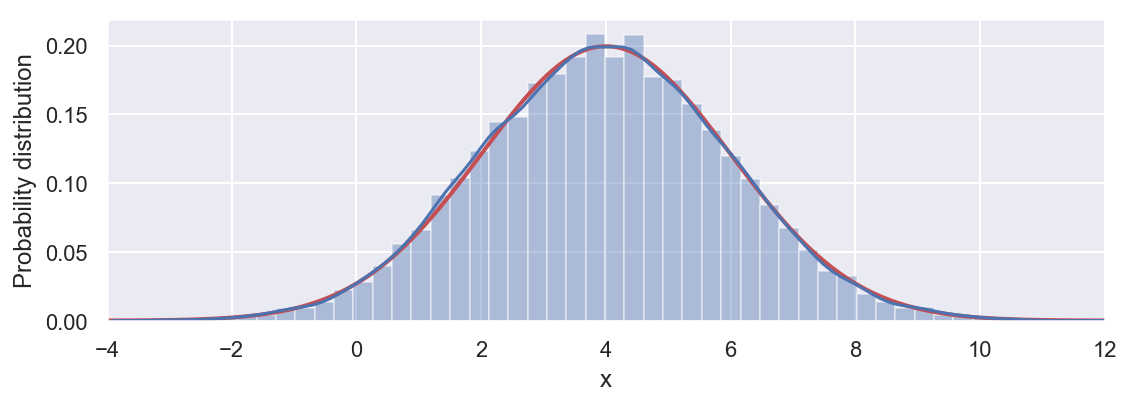

In [21]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(x, y, 'r', lw=2)
sns.distplot(X, ax=ax)
ax.set_xlim(-4, 12)
ax.set_xlabel("x")
ax.set_ylabel("Probability distribution")
fig.tight_layout()
fig.savefig("ch16-normal-distribution-sampled.pdf")

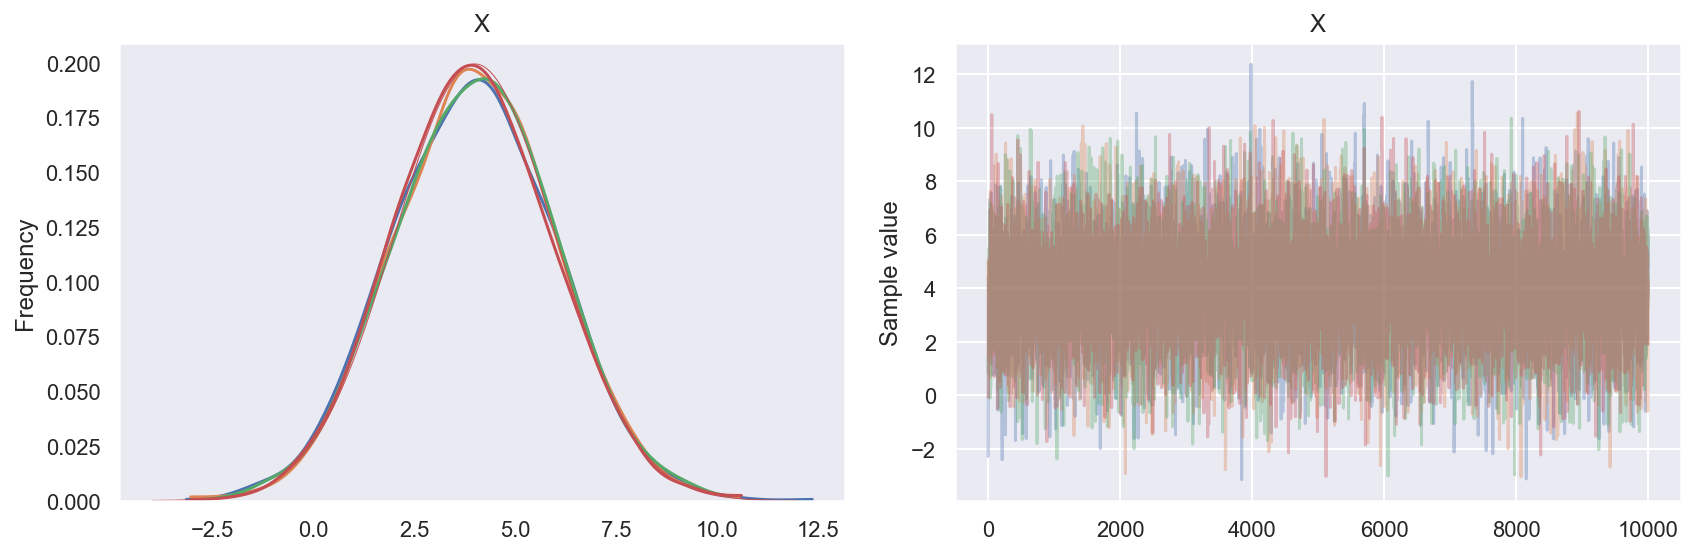

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)
mc.traceplot(trace, ax=axes)
axes[0,0].plot(x, y, 'r', lw=0.5)
fig.tight_layout()
fig.savefig("ch16-normal-sampling-trace.png")
fig.savefig("ch16-normal-sampling-trace.pdf")

## Dependent random variables

In [23]:
model = mc.Model()

In [24]:
with model:
    mean = mc.Normal('mean', 3.0)
    sigma = mc.HalfNormal('sigma', sd=1.0)
    X = mc.Normal('X', mean, tau=sigma)

In [25]:
model.vars

[mean, sigma_log__, X]

In [26]:
with model:
    start = mc.find_MAP()

/Users/rob/miniconda3/envs/py3.6/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2.4949, ||grad|| = 0.13662: 100%|██████████| 7/7 [00:00<00:00, 1168.42it/s]


In [27]:
start

{'mean': array(3.),
 'sigma_log__': array(-0.34657365),
 'X': array(3.),
 'sigma': array(0.70710674)}

In [28]:
with model:
    step = mc.Metropolis()
    trace = mc.sample(10000, start=start, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [X]
>Metropolis: [sigma]
>Metropolis: [mean]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4053.99draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [29]:
trace.get_values('sigma').mean()

0.7783082456057299

In [30]:
X = trace.get_values('X')

In [31]:
X.mean()

3.1083864227035884

In [32]:
trace.get_values('X').std()

2.843632679264834

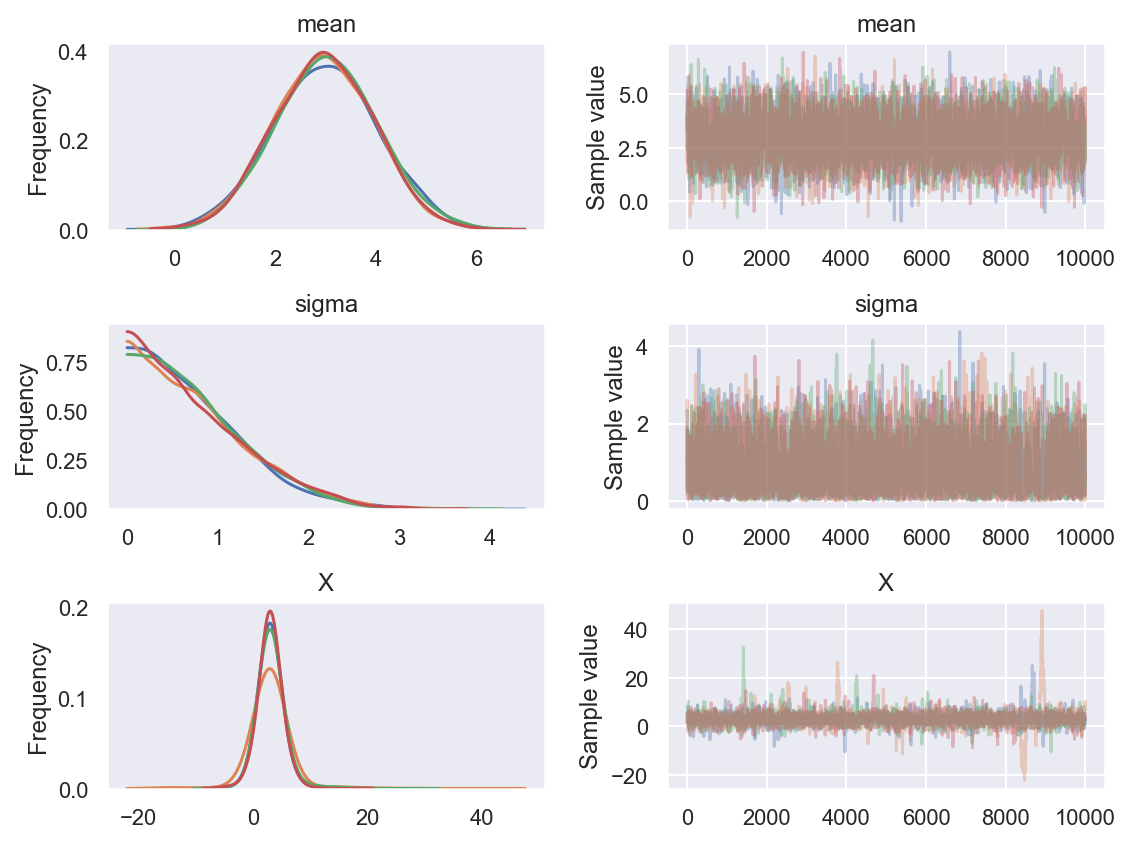

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace, varnames=['mean', 'sigma', 'X'], ax=axes)
fig.tight_layout()
fig.savefig("ch16-dependent-rv-sample-trace.png")
fig.savefig("ch16-dependent-rv-sample-trace.pdf")

## Posterior distributions

In [34]:
mu = 2.5

In [35]:
s = 1.5

In [36]:
data = stats.norm(mu, s).rvs(100)

In [37]:
with mc.Model() as model:
    
    mean = mc.Normal('mean', 4.0, tau=1.0) # true 2.5
    sigma = mc.HalfNormal('sigma', tau=3.0 * np.sqrt(np.pi/2)) # true 1.5

    X = mc.Normal('X', mean, tau=1/sigma**2, observed=data)

In [38]:
model.vars

[mean, sigma_log__]

In [39]:
with model:
    start = mc.find_MAP()
    step = mc.Metropolis()
    trace = mc.sample(10000, start=start, step=step)
    #step = mc.NUTS()
    #trace = mc.sample(10000, start=start, step=step)

/Users/rob/miniconda3/envs/py3.6/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -189.07, ||grad|| = 0.052014: 100%|██████████| 14/14 [00:00<00:00, 1754.83it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mean]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5311.96draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [40]:
start

{'mean': array(2.30048494),
 'sigma_log__': array(0.3732095),
 'sigma': array(1.45238858)}

In [41]:
model.vars

[mean, sigma_log__]

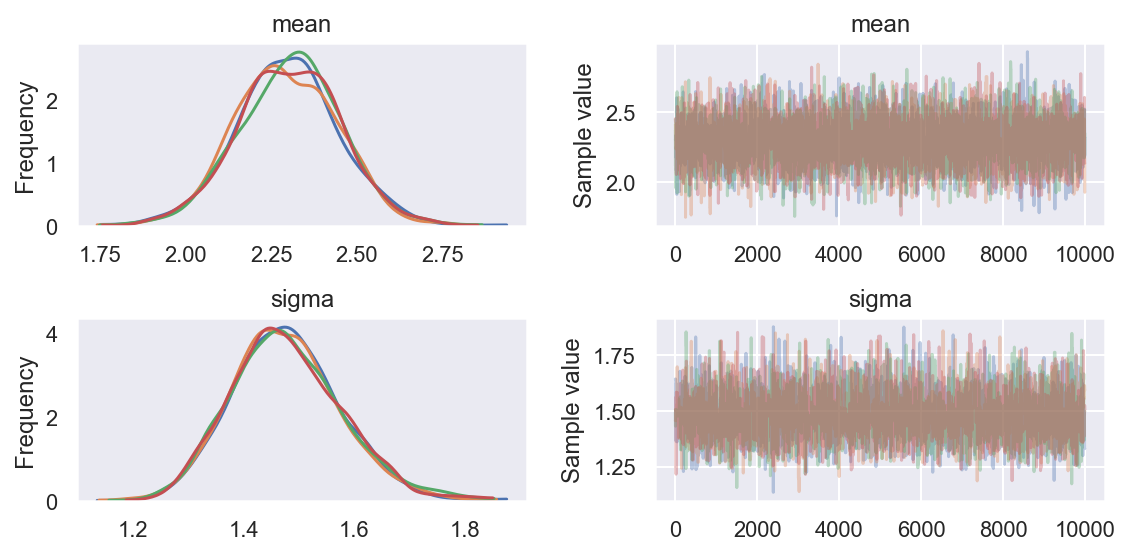

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.traceplot(trace, varnames=['mean', 'sigma'], ax=axes)
fig.tight_layout()
fig.savefig("ch16-posterior-sample-trace.png")
fig.savefig("ch16-posterior-sample-trace.pdf")

In [43]:
mu, trace.get_values('mean').mean()

(2.5, 2.300439672735639)

In [44]:
s, trace.get_values('sigma').mean()

(1.5, 1.4773833088778436)

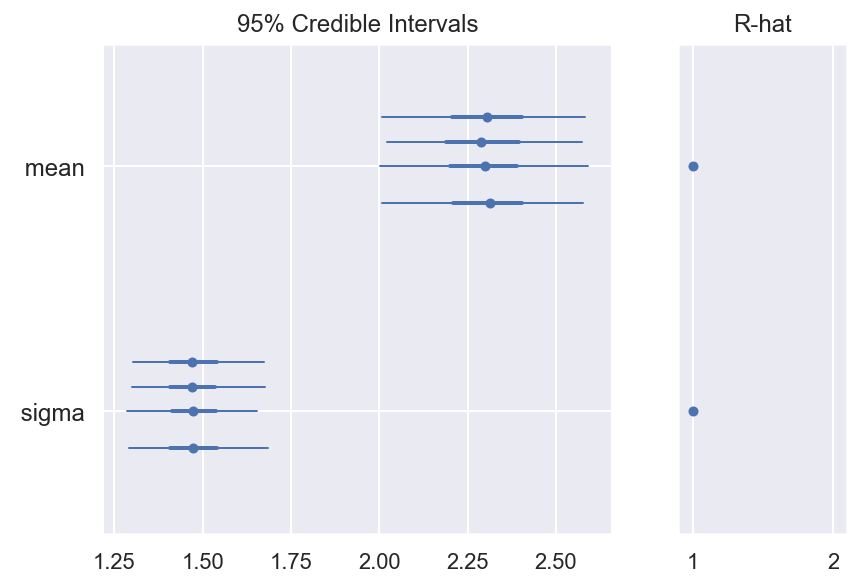

In [45]:
gs = mc.forestplot(trace, varnames=['mean', 'sigma'])
plt.savefig("ch16-forestplot.pdf")

In [46]:
help(mc.summary)

Help on function summary in module pymc3.stats:

summary(trace, varnames=None, transform=<function <lambda> at 0x1c1d6e9ae8>, stat_funcs=None, extend=False, include_transformed=False, alpha=0.05, start=0, batches=None)
    Create a data frame with summary statistics.
    
    Parameters
    ----------
    trace : MultiTrace instance
    varnames : list
        Names of variables to include in summary
    transform : callable
        Function to transform data (defaults to identity)
    stat_funcs : None or list
        A list of functions used to calculate statistics. By default,
        the mean, standard deviation, simulation standard error, and
        highest posterior density intervals are included.
    
        The functions will be given one argument, the samples for a
        variable as a 2 dimensional array, where the first axis
        corresponds to sampling iterations and the second axis
        represents the flattened variable (e.g., x__0, x__1,...). Each
        functio

In [47]:
mc.summary(trace, varnames=['mean', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,2.300440,0.147201,0.001956,2.002971,2.577492,6580.255931,1.000826
sigma,1.477383,0.098052,0.001563,1.300465,1.677372,4046.655011,1.000122


## Linear regression

In [48]:
dataset = sm.datasets.get_rdataset("Davis", "carData")

In [49]:
data = dataset.data[dataset.data.sex == 'M']

In [50]:
data = data[data.weight < 110]

In [51]:
data.head(3)

,sex,weight,height,repwt,repht
0,M,77,182,77.0,180.0
3,M,68,177,70.0,175.0
5,M,76,170,76.0,165.0


In [52]:
model = smf.ols("height ~ weight", data=data)

In [53]:
result = model.fit()

In [54]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     41.35
Date:                Mon, 06 May 2019   Prob (F-statistic):           7.11e-09
Time:                        15:52:50   Log-Likelihood:                -268.20
No. Observations:                  87   AIC:                             540.4
Df Residuals:                      85   BIC:                             545.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.6173      3.987     38.281      0.0

In [55]:
x = np.linspace(50, 110, 25)

In [56]:
y = result.predict({"weight": x})

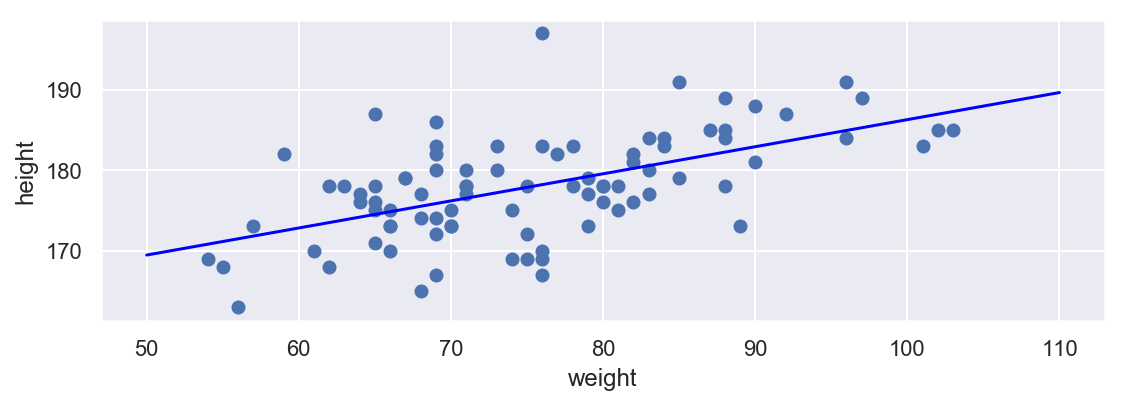

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, color="blue")
ax.set_xlabel("weight")
ax.set_ylabel("height")
fig.tight_layout()
fig.savefig("ch16-linear-ols-fit.pdf")

In [85]:
with mc.Model() as model:
    sigma = mc.Uniform('sigma', 0, 10)
    intercept = mc.Normal('intercept', 125, sd=30)
    beta = mc.Normal('beta', 0, sd=5)
    
    height_mu = intercept + beta * data.weight

    # likelihood function
    mc.Normal('height', mu=height_mu, sd=sigma, observed=data.height)

    # predict
    predict_height = mc.Normal('predict_height', mu=intercept + beta * x, sd=sigma, shape=len(x)) 

In [86]:
model.vars

[sigma_interval__, intercept, beta, predict_height]

In [87]:
# help(mc.NUTS)

In [88]:
with model:
    # start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(10000, step) # , start=start)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [predict_height, beta, intercept, sigma]
Sampling 4 chains: 100%|██████████| 42000/42000 [01:24<00:00, 495.44draws/s]
The acceptance probability does not match the target. It is 0.8815345011357728, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8914826083396686, but should be close to 0.8. Try to increase the number of tuning steps.


In [89]:
model.vars

[sigma_interval__, intercept, beta, predict_height]

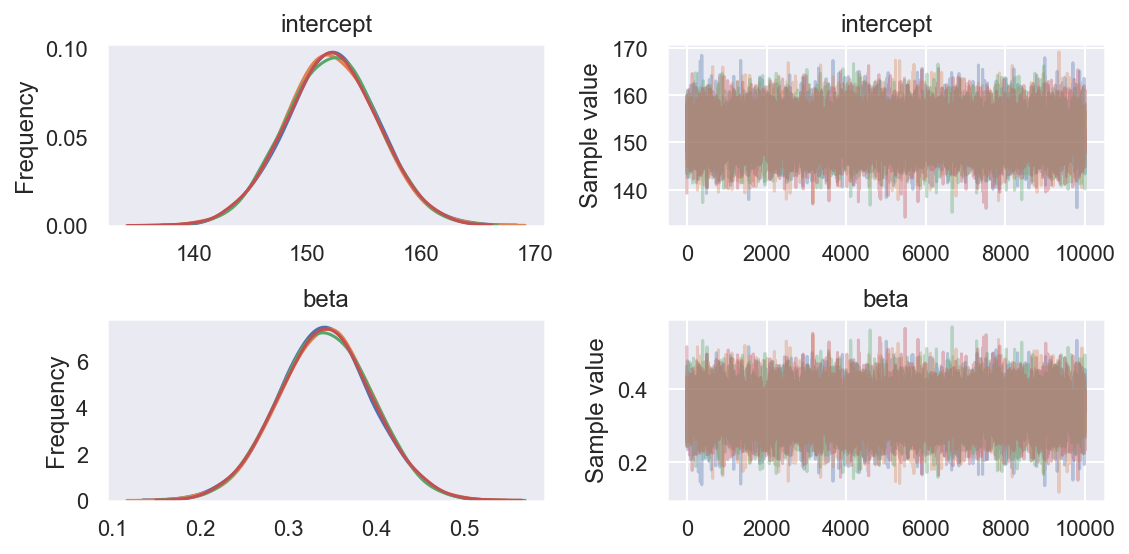

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.traceplot(trace, varnames=['intercept', 'beta'], ax=axes)
fig.savefig("ch16-linear-model-sample-trace.pdf")
fig.savefig("ch16-linear-model-sample-trace.png")

In [92]:
intercept = trace.get_values("intercept").mean()
intercept

152.15912056403442

In [93]:
beta = trace.get_values("beta").mean()
beta

0.3424401905691073

In [94]:
result.params

Intercept    152.617348
weight         0.336477
dtype: float64

In [95]:
result.predict({"weight": 90})

0    182.9003
dtype: float64

In [96]:
weight_index = np.where(x == 90)[0][0]

In [97]:
trace.get_values("predict_height")[:, weight_index].mean()

182.97564659506045

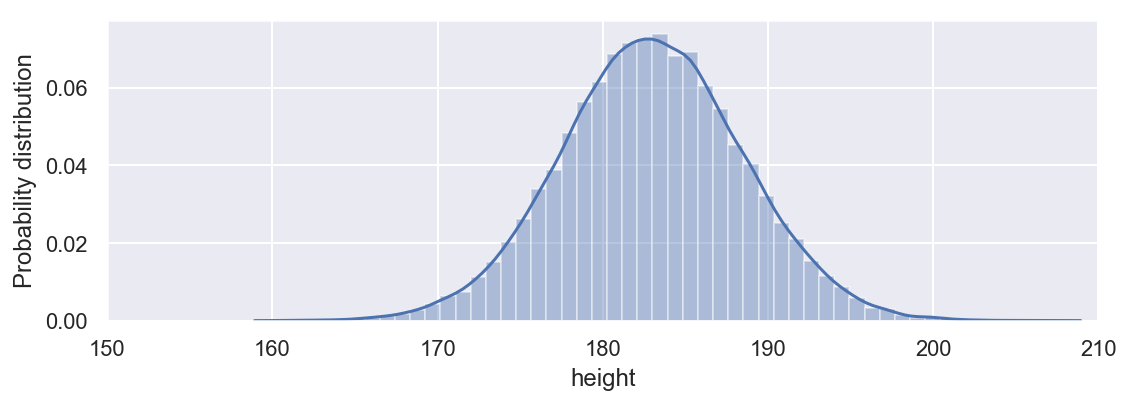

In [98]:
fig, ax = plt.subplots(figsize=(8, 3))

sns.distplot(trace.get_values("predict_height")[:, weight_index], ax=ax)
ax.set_xlim(150, 210)
ax.set_xlabel("height")
ax.set_ylabel("Probability distribution")
fig.tight_layout()
fig.savefig("ch16-linear-model-predict-cut.pdf")

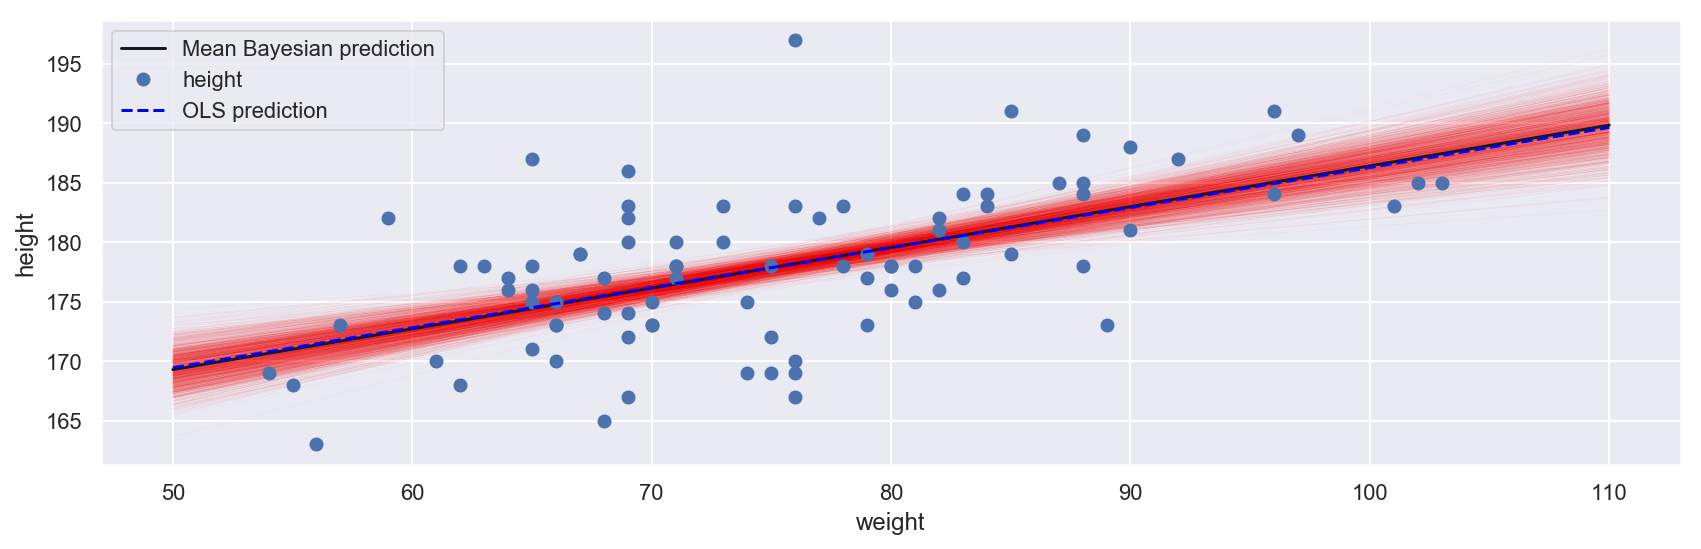

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

for n in range(500, 2000, 1):
    intercept = trace.get_values("intercept")[n]
    beta = trace.get_values("beta")[n]
    ax.plot(x, intercept + beta * x, color='red', lw=0.25, alpha=0.05)

intercept = trace.get_values("intercept").mean()
beta = trace.get_values("beta").mean()
ax.plot(x, intercept + beta * x, color='k', label="Mean Bayesian prediction")

ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, '--', color="blue", label="OLS prediction")
ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch16-linear-model-fit.pdf")
fig.savefig("ch16-linear-model-fit.png")

In [100]:
with mc.Model() as model:
    mc.glm.GLM.from_formula('height ~ weight', data)
    step = mc.NUTS()
    trace = mc.sample(2000, step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, weight, Intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:15<00:00, 634.51draws/s]
The acceptance probability does not match the target. It is 0.8788452420871716, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9413562668375693, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9289299829864369, but should be close to 0.8. Try to increase the number of tuning steps.


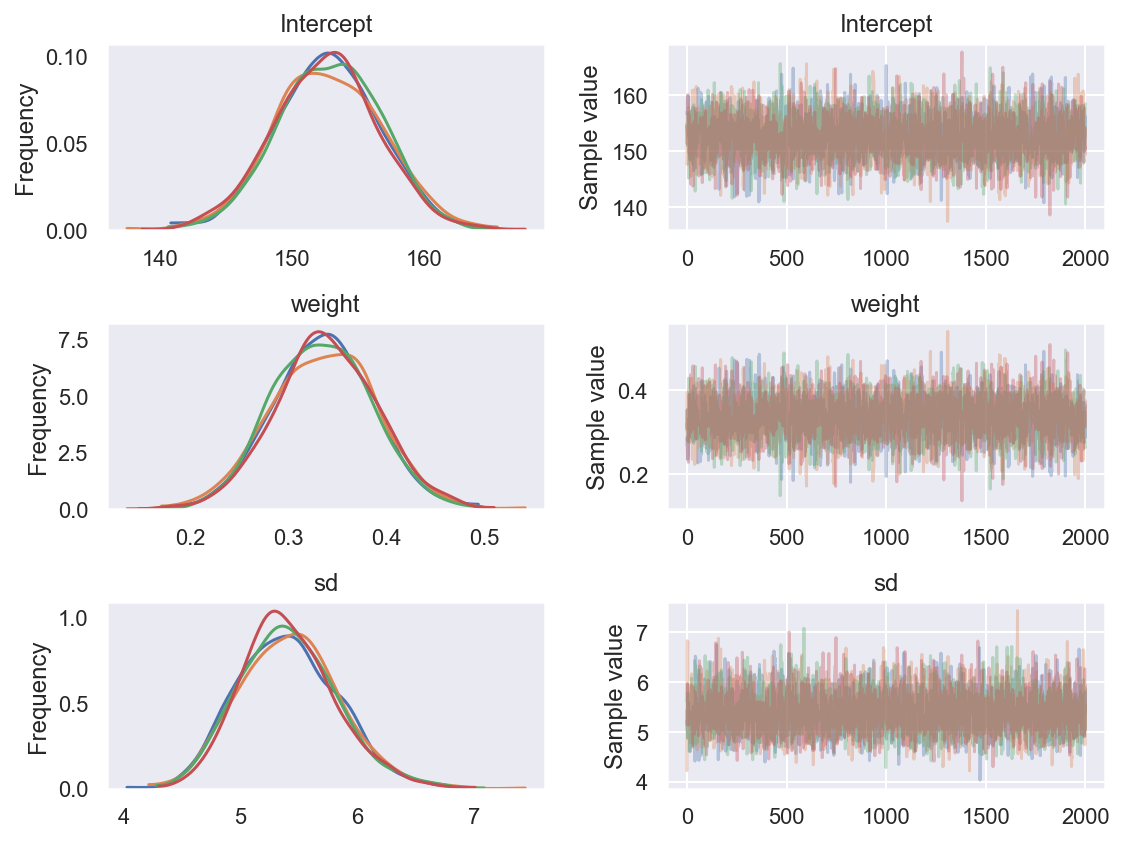

In [101]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace, varnames=['Intercept', 'weight', 'sd'], ax=axes)
fig.tight_layout()
fig.savefig("ch16-glm-sample-trace.pdf")
fig.savefig("ch16-glm-sample-trace.png")

## Multilevel model

In [102]:
dataset = sm.datasets.get_rdataset("Davis", "carData")

In [103]:
data = dataset.data.copy()
data = data[data.weight < 110]

In [104]:
data["sex"] = data["sex"].apply(lambda x: 1 if x == "F" else 0)

In [105]:
data.head()

,sex,weight,height,repwt,repht
0,0,77,182,77.0,180.0
1,1,58,161,51.0,159.0
2,1,53,161,54.0,158.0
3,0,68,177,70.0,175.0
4,1,59,157,59.0,155.0


In [106]:
with mc.Model() as model:

    # heirarchical model: hyper priors
    #intercept_mu = mc.Normal("intercept_mu", 125)
    #intercept_sigma = 30.0 #mc.Uniform('intercept_sigma', lower=0, upper=50)
    #beta_mu = mc.Normal("beta_mu", 0.0)
    #beta_sigma = 5.0 #mc.Uniform('beta_sigma', lower=0, upper=10)
    
    # multilevel model: prior parameters
    intercept_mu, intercept_sigma = 125, 30
    beta_mu, beta_sigma = 0.0, 5.0
    
    # priors
    intercept = mc.Normal('intercept', intercept_mu, sd=intercept_sigma, shape=2)
    beta = mc.Normal('beta', beta_mu, sd=beta_sigma, shape=2)
    error = mc.Uniform('error', 0, 10)

    # model equation
    sex_idx = data.sex.values
    height_mu = intercept[sex_idx] + beta[sex_idx] * data.weight

    mc.Normal('height', mu=height_mu, sd=error, observed=data.height)

In [107]:
model.vars

[intercept, beta, error_interval__]

In [108]:
with model:
    start = mc.find_MAP()
    # hessian = mc.find_hessian(start)
    step = mc.NUTS()
    trace = mc.sample(5000, step, start=start)

/Users/rob/miniconda3/envs/py3.6/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -618.03, ||grad|| = 8.8049: 100%|██████████| 51/51 [00:00<00:00, 1715.39it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, beta, intercept]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:51<00:00, 428.65draws/s]


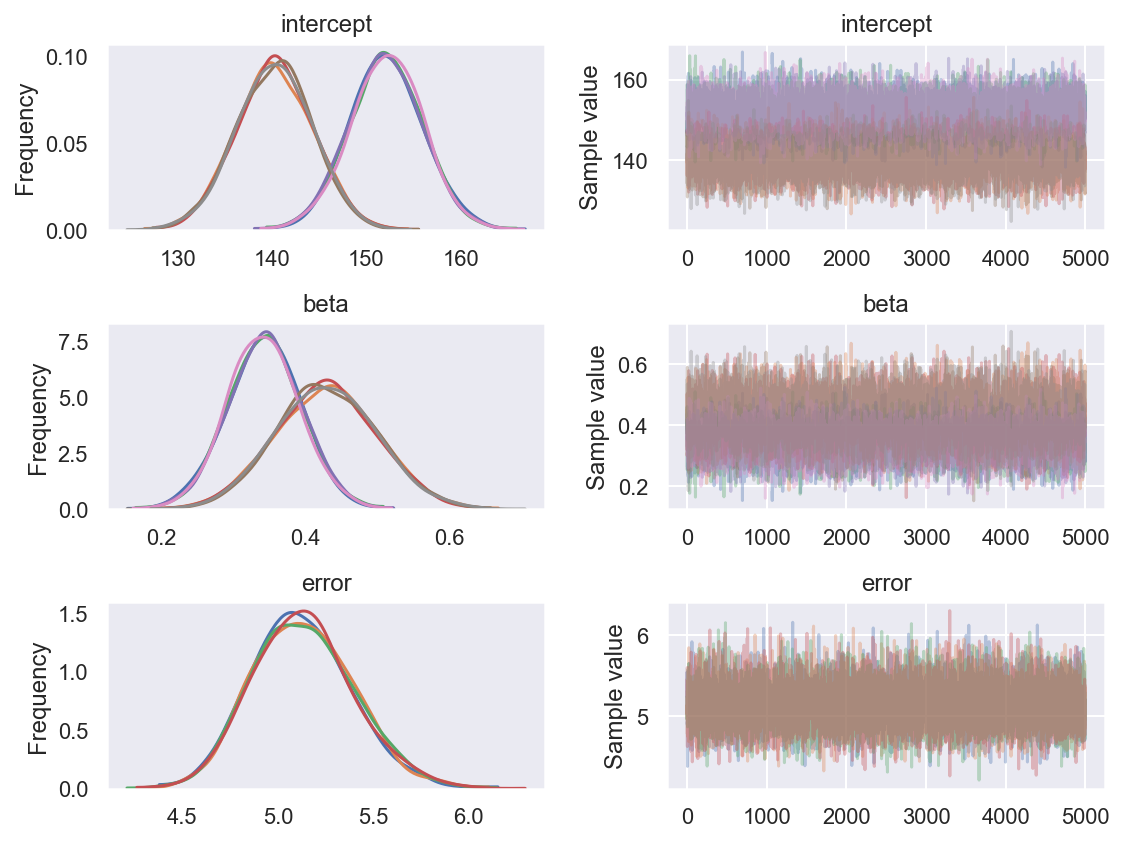

In [109]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace, varnames=['intercept', 'beta', 'error'], ax=axes)
fig.tight_layout()
fig.savefig("ch16-multilevel-sample-trace.pdf")
fig.savefig("ch16-multilevel-sample-trace.png")

In [110]:
intercept_m, intercept_f = trace.get_values('intercept').mean(axis=0)

In [111]:
intercept = trace.get_values('intercept').mean()

In [112]:
beta_m, beta_f = trace.get_values('beta').mean(axis=0)

In [113]:
beta = trace.get_values('beta').mean()

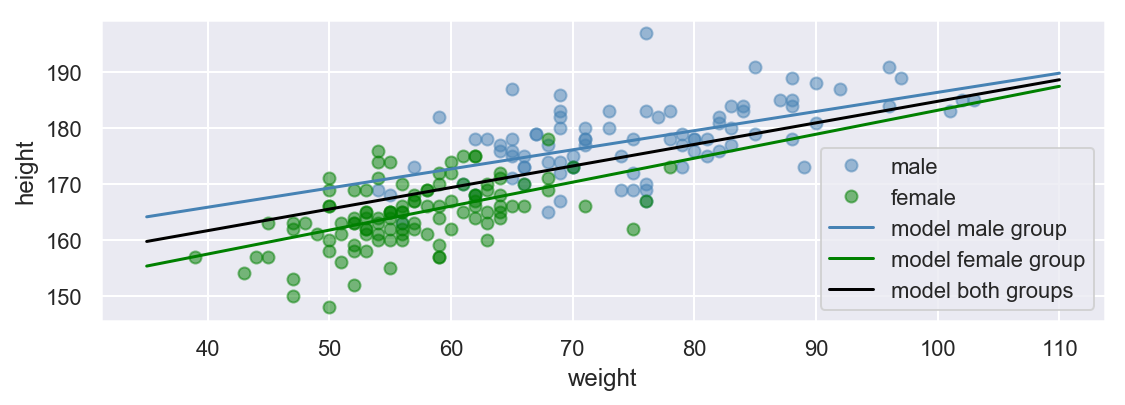

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

mask_m = data.sex == 0
mask_f = data.sex == 1

ax.plot(data.weight[mask_m], data.height[mask_m], 'o', color="steelblue", label="male", alpha=0.5)
ax.plot(data.weight[mask_f], data.height[mask_f], 'o', color="green", label="female", alpha=0.5)

x = np.linspace(35, 110, 50)
ax.plot(x, intercept_m + x * beta_m, color="steelblue", label="model male group")
ax.plot(x, intercept_f + x * beta_f, color="green", label="model female group")
ax.plot(x, intercept + x * beta, color="black", label="model both groups")

ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch16-multilevel-linear-model-fit.pdf")
fig.savefig("ch16-multilevel-linear-model-fit.png")

In [115]:
trace.get_values('error').mean()

5.131501939157903

# Version

In [116]:
%reload_ext version_information

In [118]:
%version_information numpy, pandas, matplotlib, statsmodels, pymc3, theano

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.5.0
OS Darwin 18.2.0 x86_64 i386 64bit
numpy 1.16.3
pandas 0.24.2
matplotlib 3.0.3
statsmodels 0.9.0
pymc3 3.6
theano 1.0.4
Mon May 06 16:13:39 2019 JST